In [175]:
from qiskit import Aer, QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.compiler import transpile


import numpy as np
pi = np.pi

backend = Aer.get_backend('qasm_simulator')

In [271]:
def quad_cost_circ(γ, Q, B):
    """Return a quantum circuit for the quadratic part of the given QUBO 
    specified by the matrix Q. γ is a given parameter. """
    
    n = len(B)
    circ = QuantumCircuit(n, name='quad_cost')
    
    # Construct the quadratic part
    for i in range(n):
        for j in range(i+1, n):
            circ.cx(i,j)
            phase = 0
            if (i,j) in Q:
                phase += γ * Q[(i,j)]
            if (j,i) in Q:
                phase += γ * Q[(j,i)]       
            if phase != 0:
                circ.rz(2 * phase, j)
            circ.cx(i,j)
        
    return circ

def AQC_circ(Q, B, p):
    """Return a parametrized circuit with 2p parameters"""

    n = len(B) # number of qubits
    qr = QuantumRegister(n)
    circ = QuantumCircuit(qr)

    # The linear phase from Q
    coef = 0
    for i in range(n):
        if (i,i) in Q:
            coef += Q[(i,i)]    
            
    # Construct the initial state
    circ.x(0)
    for i in range(n):
        circ.h(i)
    circ.barrier()
    
#     for ind in range(p):
    for ind in range(85):
        γ = Parameter(f"γ_{ind}")
        β = Parameter(f"β_{ind}")
        
        # Construct the linear part, and mixer part 
        for i in range(n):
            circ.rx(β * pi, i)
#             phase_z = γ * coef + B[i]
#             phase_x = β * pi
#             θ, ϕ, λ = phase_x, -pi/2, phase_z-pi/2
#             circ.u(θ, ϕ, λ, i)
            
            
        circ.append(quad_cost_circ(γ, Q, B), qr)
        
        if ind != p-1:
            circ.barrier()
        
#     circ.measure_all()

    return circ

def AQC(Q, B, p=2, backend = Aer.get_backend('qasm_simulator'), shots = 1000):
    circ = AQC_circ(Q, B, p)

    γ = [(i+1)/p for i in range(p+1)]
    β = [1-(i+1)/p for i in range(p+1)]
    paras = γ + β

    circ_para = circ.bind_parameters(dict(zip(circ.parameters, paras)))
    
    circ_transpile = transpile(circ_para, backend=backend, seed_transpiler=42, optimization_level=3)

    counts = backend.run(circ_transpile, shots=shots).result().get_counts()
    counts = {tuple([int(kk) for kk in k]): v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}    

    return circ, counts    


In [272]:
n = 2
Q = {}
B = {}
for i in range(n):
    B[i] = 0
    for j in range(i+1, n):
        Q[(i,j)] = 1

In [273]:
# p = 10
# circ, counts = AQC(Q, B, p)
# # circ.draw('mpl')
# counts

[-0.49641989+0.05972683j  0.49641989+0.05972683j -0.49641989-0.05972683j
  0.49641989-0.05972683j]


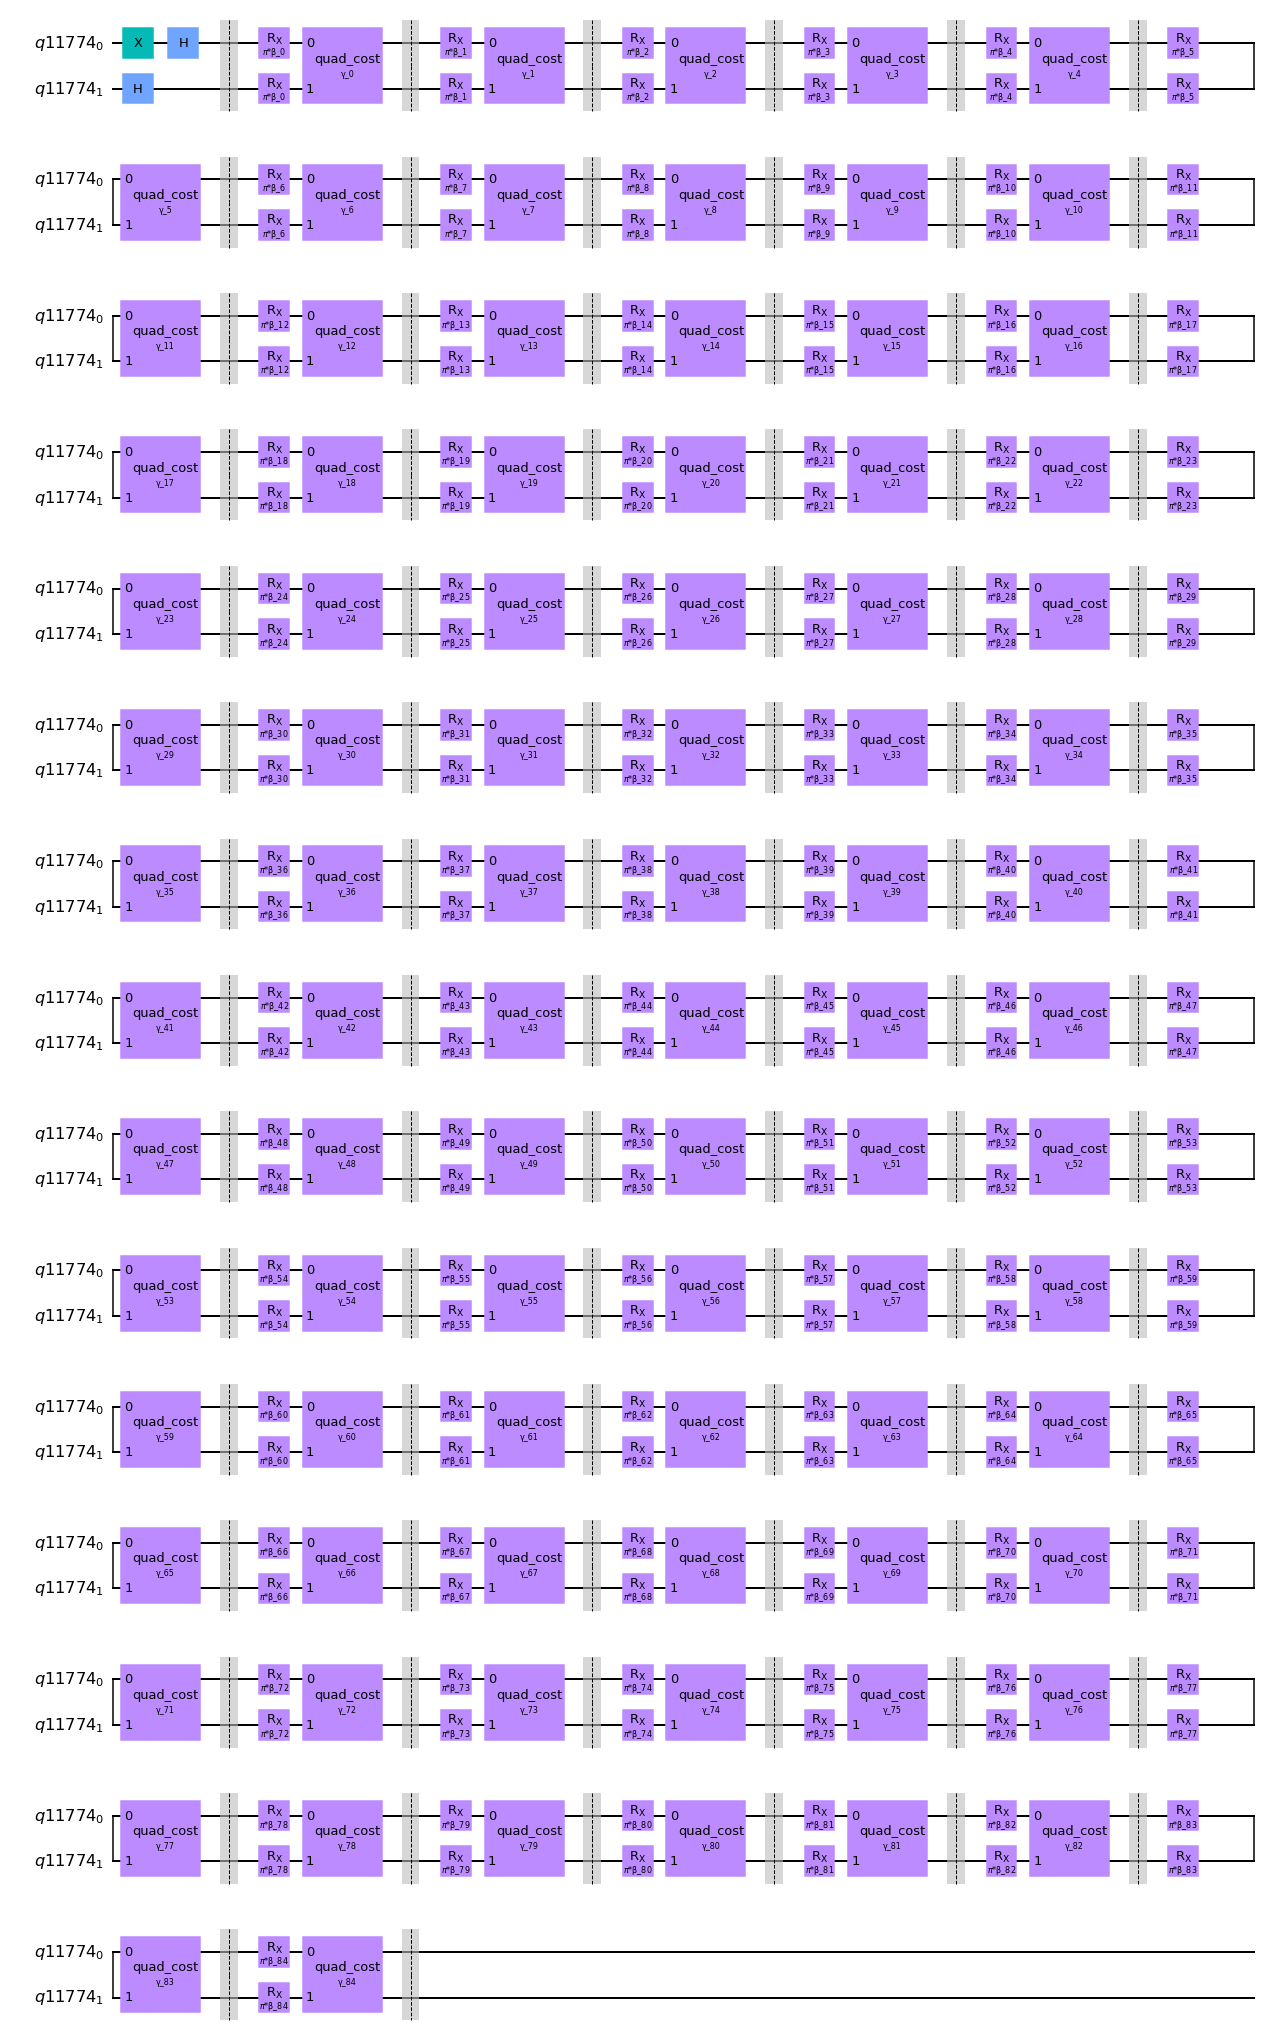

In [274]:
backend = Aer.get_backend('statevector_simulator')
p = 100
γ = [(i+1)/p for i in range(p+1)]
β = [1-(i+1)/p for i in range(p+1)]
paras = γ + β

circ = AQC_circ(Q, B, p)
circ_para = circ.bind_parameters(dict(zip(circ.parameters, paras)))

circ_transpile = transpile(circ_para, backend=backend, seed_transpiler=42, optimization_level=3)

vec = backend.run(circ_transpile).result().get_statevector()
print(vec)

circ.draw('mpl')

In [266]:
# [ 0.5+0.000000e+00j -0.5-6.123234e-17j  0.5+0.000000e+00j
#  -0.5-6.123234e-17j]

# [-0.37598871+0.32959443j  0.37598871+0.32959443j -0.37598871-0.32959443j
#   0.37598871-0.32959443j]